In [1]:
import pandas as pd
from kaggle.api.kaggle_api_extended import KaggleApi
from pandas_profiling import ProfileReport

- Read in churn dataset, exploratory analysis (heat matrix of correlation)
- build a model - decision tree? to model and understand. 
                - What are the weights? - do we need multiple models? 
- predict risk, instead of categories, profile the customer based on that... no need to worry about low-risk (or praise)

In [7]:
download = False

if download: 
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files('shrutimechlearn/churn-modelling', path='kaggle_datasets', unzip=True)

In [8]:
#!pip3 install pandas-profiling[notebook]
# !pip install xgboost

In [235]:
df = pd.read_csv('kaggle_datasets/Churn_Modelling.csv')
df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Gender'])
df.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,41,1,83807.86,1,0,1,112542.58,0
2,502,France,42,8,159660.80,3,1,0,113931.57,1
3,699,France,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,43,2,125510.82,1,1,1,79084.10,0


In [232]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [135]:
# profile = ProfileReport(df, title='Churn Dataset Profiling Report', explorative = True)
# profile

## Prep data for modelling 

In [233]:
def get_int_col(in_df):
    in_df = in_df.reset_index()
    in_df['index'] = in_df['index'].astype(int)
    return in_df
    
def get_dummies(in_df, column):
    dum_df = pd.get_dummies(in_df[column])
    l1 = [i for i in dum_df.columns]
    l2 = ['%s_'%i+column for i in dum_df.columns]
    for i in range(0, len(l1)):
        dum_df = dum_df.rename(index=str,columns={l1[i]:l2[i]})  
    return get_int_col(dum_df)

def merge_dfs(df1, df2, column):
    df1 = df1.merge(df2, left_on='index', right_on='index').set_index('index')
    df1 = df1.drop(columns=column)
    return df1

In [234]:
geo_df = get_dummies(df, 'Geography')
num_prod_df = get_dummies(df, 'NumOfProducts')
cr_card_df = get_dummies(df, 'HasCrCard')
act_memb_df = get_dummies(df, 'IsActiveMember')

In [236]:
geo_df.head()

,index,France_Geography,Germany_Geography,Spain_Geography
0,0,1,0,0
1,1,0,0,1
2,2,1,0,0
3,3,1,0,0
4,4,0,0,1


In [139]:
df = get_int_col(df)

df = merge_dfs(df, geo_df, 'Geography')
df = merge_dfs(df, num_prod_df, 'NumOfProducts')
df = merge_dfs(df, cr_card_df, 'HasCrCard')
df = merge_dfs(df, act_memb_df, 'IsActiveMember')

df.head()

,CreditScore,Age,Tenure,Balance,EstimatedSalary,Exited,France_Geography,Germany_Geography,Spain_Geography,1_NumOfProducts,2_NumOfProducts,3_NumOfProducts,4_NumOfProducts,0_HasCrCard,1_HasCrCard,0_IsActiveMember,1_IsActiveMember
index,,,,,,,,,,,,,,,,,
0,619,42,2,0.00,101348.88,1,1,0,0,1,0,0,0,0,1,0,1
1,608,41,1,83807.86,112542.58,0,0,0,1,1,0,0,0,1,0,0,1
2,502,42,8,159660.80,113931.57,1,1,0,0,0,0,1,0,0,1,1,0
3,699,39,1,0.00,93826.63,0,1,0,0,0,1,0,0,1,0,1,0
4,850,43,2,125510.82,79084.10,0,0,0,1,1,0,0,0,0,1,0,1


## Select x and y

In [140]:
X = df.drop(columns=['Exited'])
y = df['Exited'].values

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Fit model

In [144]:
# Training the Logistic Regression model on the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [145]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [146]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[1532,   63],
       [ 245,  160]])

In [147]:
(160+1532)/(160+1532+245+63)

0.846

In [148]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print(accuracies.mean())
print(accuracies.std())

0.8391249999999999
0.008311325104939645


## Get the probabilities

In [149]:
y_pred_proba = classifier.predict_proba(X)

In [150]:
proba_df = pd.DataFrame(y_pred_proba)
proba_df['y_test'] = y

In [151]:
proba_df = proba_df.rename(columns={0:'retention_proba', 1:'churn_proba'})

In [152]:
def func(row):
    if row['churn_proba']<=0.2: 
        return "Low risk"
    elif 0.2<row['churn_proba']<=0.8: 
        return 'Medium risk'
    else:
        return 'High risk'

proba_df['risk_rating'] = proba_df.apply(func, axis=1)

In [153]:
proba_df.sample(10)

,retention_proba,churn_proba,y_test,risk_rating
980,0.835876,0.164124,0,Low risk
7693,0.733243,0.266757,0,Medium risk
2653,0.846392,0.153608,0,Low risk
1063,0.920619,0.079381,0,Low risk
3954,0.924448,0.075552,0,Low risk
2983,0.775632,0.224368,0,Medium risk
6295,0.062040,0.937960,1,High risk
7269,0.600294,0.399706,1,Medium risk
793,0.791271,0.208729,0,Medium risk
583,0.646339,0.353661,0,Medium risk


In [154]:
proba_df[proba_df['risk_rating']=='Low risk'].shape

(6402, 4)

In [170]:
grouped_proba_df = proba_df['risk_rating'].value_counts().reset_index()

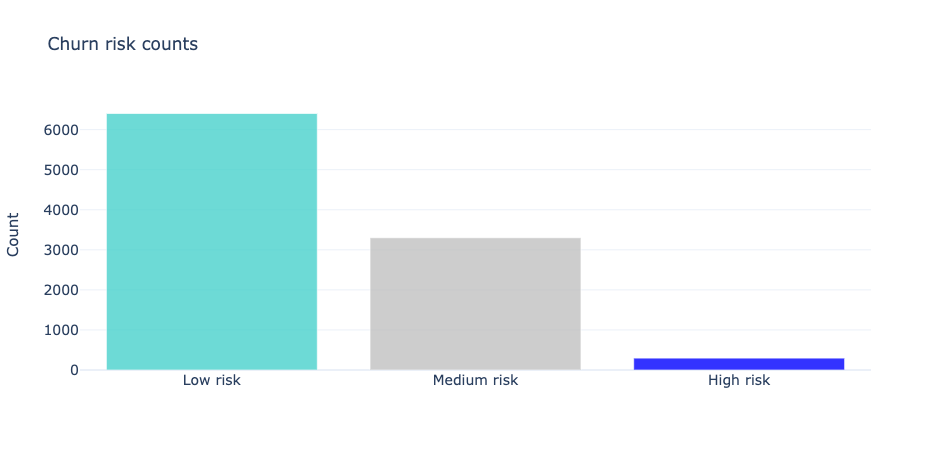

In [227]:
import plotly.graph_objects as go

colors = [ 'mediumturquoise', 'silver', 'blue'] 

fig = go.Figure(data=[go.Bar(
    x=proba_df['risk_rating'].value_counts().reset_index()['index'],
    y=proba_df['risk_rating'].value_counts().reset_index()['risk_rating'],
    opacity=0.8,
    marker_color=colors # marker color can be a single color value or an iterable
)])
fig.update_layout(title_text='Churn risk counts', 
                  yaxis_title_text='Count',
                  xaxis=dict(
                        titlefont_size=15,
                        tickfont_size=14,
                    ), 
                  yaxis=dict(
                        titlefont_size=15,
                        tickfont_size=14,
                    ), 
                  template='plotly_white' 
                 )

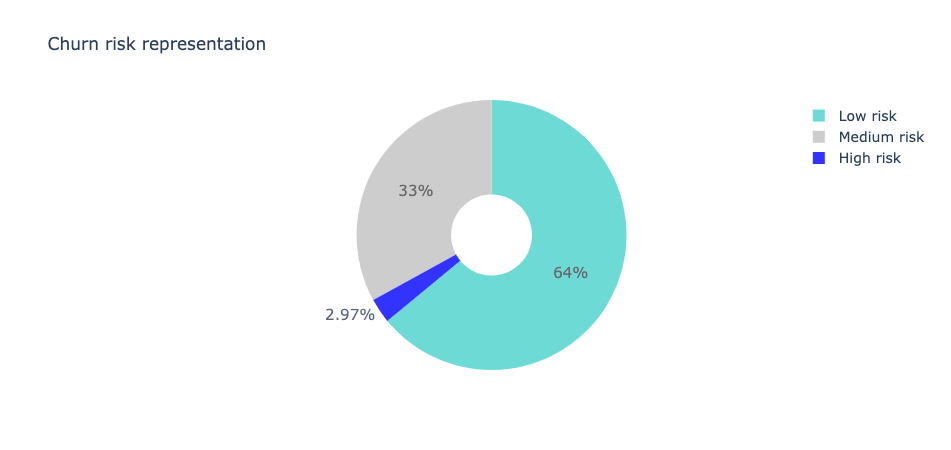

In [228]:
import plotly.graph_objects as go

colors = [ 'mediumturquoise', 'silver', 'blue'] 


# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=proba_df['risk_rating'].value_counts().reset_index()['index'], 
                             values=proba_df['risk_rating'].value_counts().reset_index()['risk_rating'], 
                             textfont_size=15,
                             opacity=0.8,
                             marker_colors=colors, 
                             hole=.3)])


fig.update_layout(title_text='Churn risk representation', 
                  template='plotly_white',
                  legend=dict(
                        font=dict(
                            size=14,
                        ),)
                  
                 )
fig.show()

In [143]:
# from sklearn.tree import DecisionTreeRegressor
# regressor = DecisionTreeRegressor(random_state = 0)
# regressor.fit(X_train, y_train)